## **Home Work 2: Nonlinear Control: Inverse Dynamics, Robust and Adaptive control**
### Ostapovich Oleg

### **Vessel on the River**

Consider a folowing vessel on the river:

<p align="center">
<img src="https://blog.arduino.cc/wp-content/uploads/2021/11/DawveRf-1024x683.jpeg" alt="drawing" width="35%" style="margin:auto"/>
</p>




With differential kinematics described as follows:
$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}
\\
\dot{y}
\\
\dot{\theta}
\end{bmatrix}
=
\begin{bmatrix}
 \cos \theta & -\sin \theta & 0\\
 \sin \theta & \cos \theta & 0\\
 0 & 0 & 1\\
\end{bmatrix}
\begin{bmatrix}
v_\tau
\\
v_n
\\
\omega
\end{bmatrix} 
+
\begin{bmatrix}
\delta \\
0 \\
0\\
\end{bmatrix}
= \mathbf{R}(\theta)\mathbf{u} + \boldsymbol{\delta}(t)
$$

where $x, y$ are cartesian coordinates w.r.t global frame, $\theta$ heading angle, $0<\delta<\delta_{max}$ river flow $v_\tau, v_n, \omega$ are linear and angular velocity of vessel w.r.t. local coordinate frame.

<p align="center">
<img src="https://drive.google.com/uc?id=14Y5dheMte0hTe7MGCLE143wXmgJx96NR" alt="drawing" hspace="300px" width="50%" style="margin:auto"/>
</p>




In [327]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [328]:
def Rz(theta):
    mtx = [[np.cos(theta),-np.sin(theta),0],
           [np.sin(theta),np.cos(theta),0],
           [0,0,1]]
    return np.array(mtx)

In [329]:
def plotting(t, state, x_d, y_d, th_d):
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('X(t)')
    plt.plot(t, state[:, 0])
    plt.plot(t, x_d, color='black', linestyle='--')
    plt.subplot(132)
    plt.title('Y(t)')
    plt.plot(t, state[:, 1])
    plt.plot(t, y_d, color='black', linestyle='--')
    plt.subplot(133)
    plt.title('Theta(t)')
    plt.plot(t, state[:, 2])
    plt.plot(t, th_d, color='black', linestyle='--')
    plt.show()

### Task 1: Inverse dynamics:
  * Assuming for now that river flow $\delta = 0$, propose the inverse dynamics control that regulate vessel to the desired state

In [330]:
# Time settings
t0 = 0                     # Initial time
tf = 2*np.pi*5             # Final time
N = int(1E3)               # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

#Desired states:
x_d = 30
y_d = 10
th_d = 1

# Define initial point:
x_0 = 3
y_0 = 5
theta_0 = 2

# Set initial state
x0 = np.array([x_0, y_0, theta_0])
poles = [1,2,3]

In [331]:
def Control(x, t, poles):
    u = np.array([[-poles[0] * (x[0,0]-x_d)],
                  [-poles[1] * (x[1,0]-y_d)],
                  [-poles[2] * (x[2,0]-th_d)]])
    u = Rz(x[2,0]).T@u
    return u

In [332]:
def System(x, t):
    x = np.array(x, dtype='float').reshape((-1, 1))
    v = Control(x, t, poles)
    R = Rz(x[2,0])
    dx_dt = R@v
    return dx_dt.reshape(3)

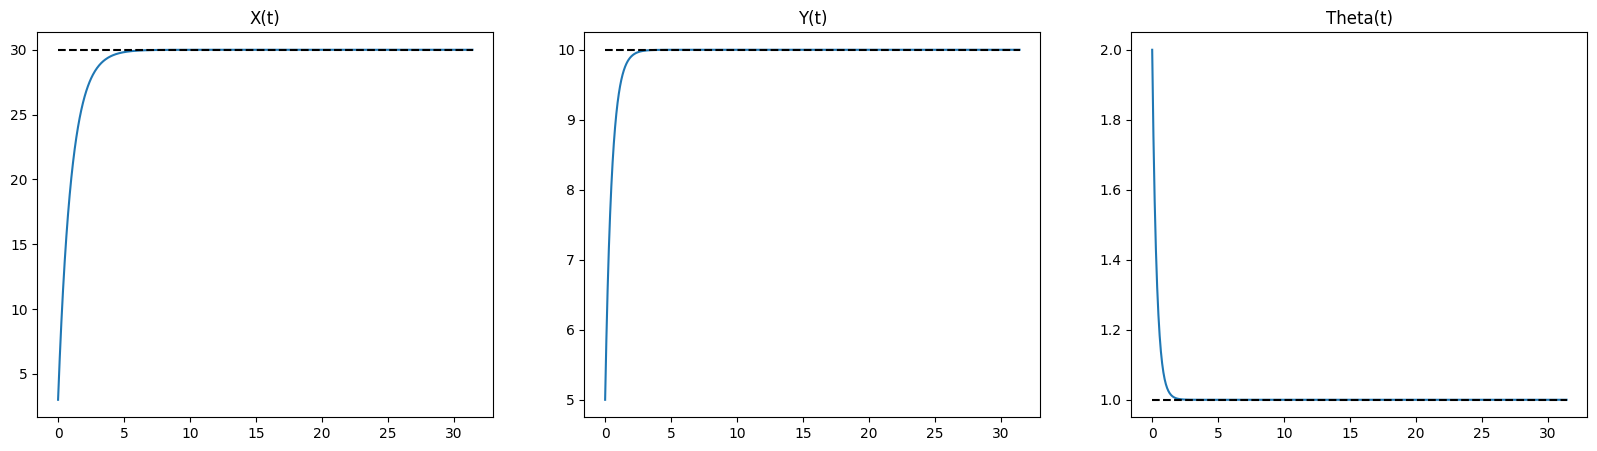

In [333]:
state = odeint(System, x0, t)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('X(t)')
plt.plot(t, state[:, 0])
plt.hlines(x_d, 0, t[-1], color='black', linestyle='--')
plt.subplot(132)
plt.title('Y(t)')
plt.plot(t, state[:, 1])
plt.hlines(y_d, 0, t[-1], color='black', linestyle='--')
plt.subplot(133)
plt.title('Theta(t)')
plt.plot(t, state[:, 2])
plt.hlines(th_d, 0, t[-1], color='black', linestyle='--')
plt.show()

  * Modify controller to track time varying trajectories, take for instance $x_d = 10\cos t/5, y_d = 10\sin t/5, \theta_d = \pi/2 + t/5$

In [334]:
def Control(x, t, poles):
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5
    u = np.array([[-poles[0] * (x[0,0]- x_t)- 2*np.sin(t/5)],
                  [-poles[1] * (x[1,0]- y_t) + 2*np.cos(t/5)],
                  [-poles[2] * (x[2,0]- theta_t) + 1/5]])
    u = Rz(x[2,0]).T@u
    return u

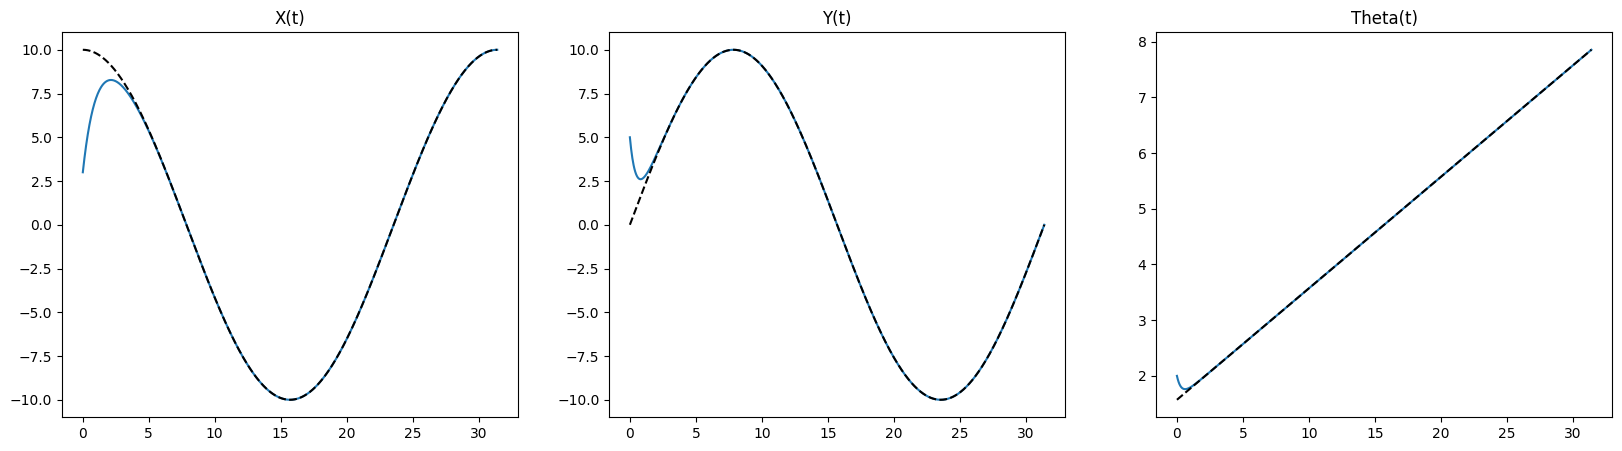

In [335]:
state = odeint(System, x0, t)

#Used only for plotting
x_d = 10 * np.cos(t/5)
y_d = 10 * np.sin(t/5)
th_d = np.pi/2 + t/5

plotting(t,state,x_d,y_d,th_d)

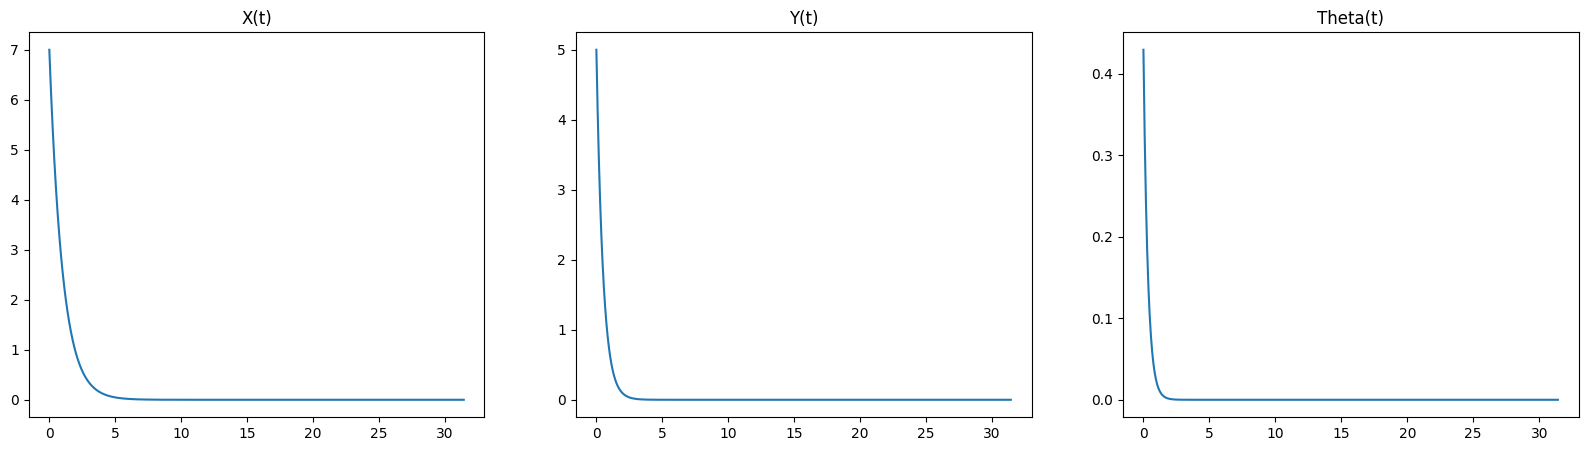

In [336]:
# Plots of errors
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('X(t)')
plt.plot(t, np.abs(state[:, 0] - x_d))
plt.subplot(132)
plt.title('Y(t)')
plt.plot(t, np.abs(state[:, 1] - y_d))
plt.subplot(133)
plt.title('Theta(t)')
plt.plot(t, np.abs(state[:, 2] - th_d))
plt.show()

  * Tune the controller such that you will have critically damped response and less controll effort in the $n$ direction.
  * Simulate the response for both tracking and regulation.

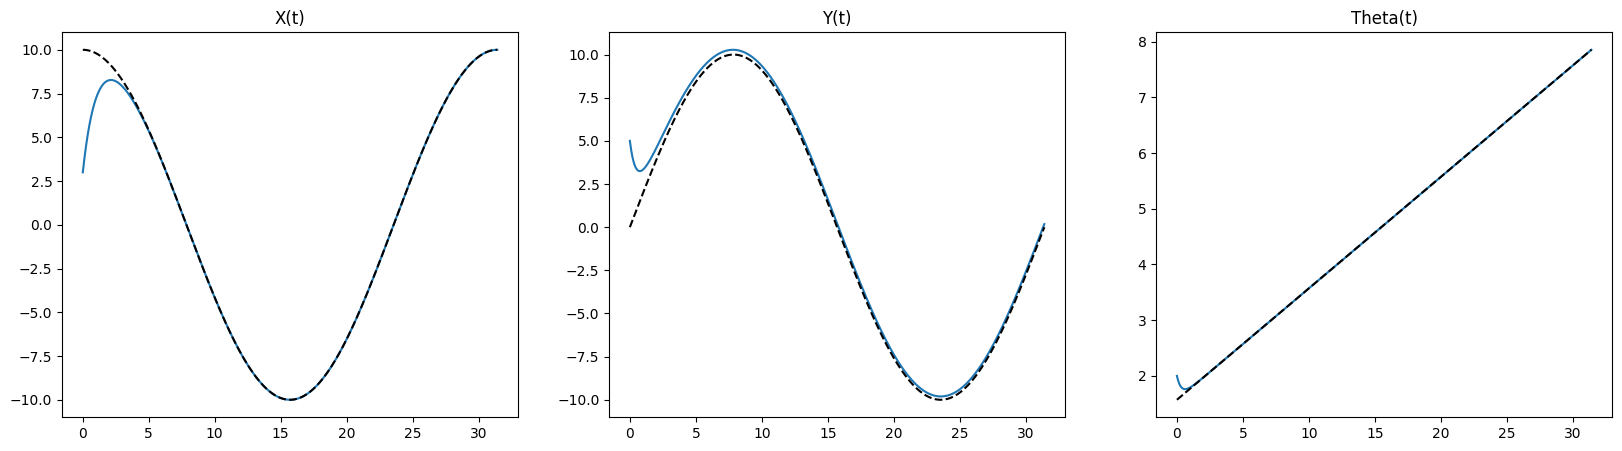

In [337]:
def Control(x, t, poles):
    less_k = poles[1]
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5
    less_k = less_k * np.exp(-1/(x[1,0]-y_t))
    less_k_list.append(less_k)
    u = np.array([[-poles[0] * (x[0,0]- x_t)- 2*np.sin(t/5)],
                  [-less_k * (x[1,0]- y_t) + 2*np.cos(t/5)],
                  [-poles[2] * (x[2,0]- theta_t) + 1/5]])
    u = Rz(x[2,0]).T@u
    return u
less_k_list = []
state = odeint(System, x0, t)

#Used only for plotting
x_d = 10 * np.cos(t/5)
y_d = 10 * np.sin(t/5)
th_d = np.pi/2 + t/5

plotting(t,state,x_d,y_d,th_d)

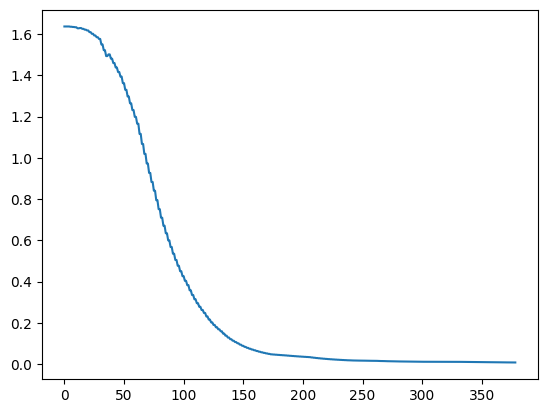

In [338]:
plt.plot(less_k_list)
plt.show()

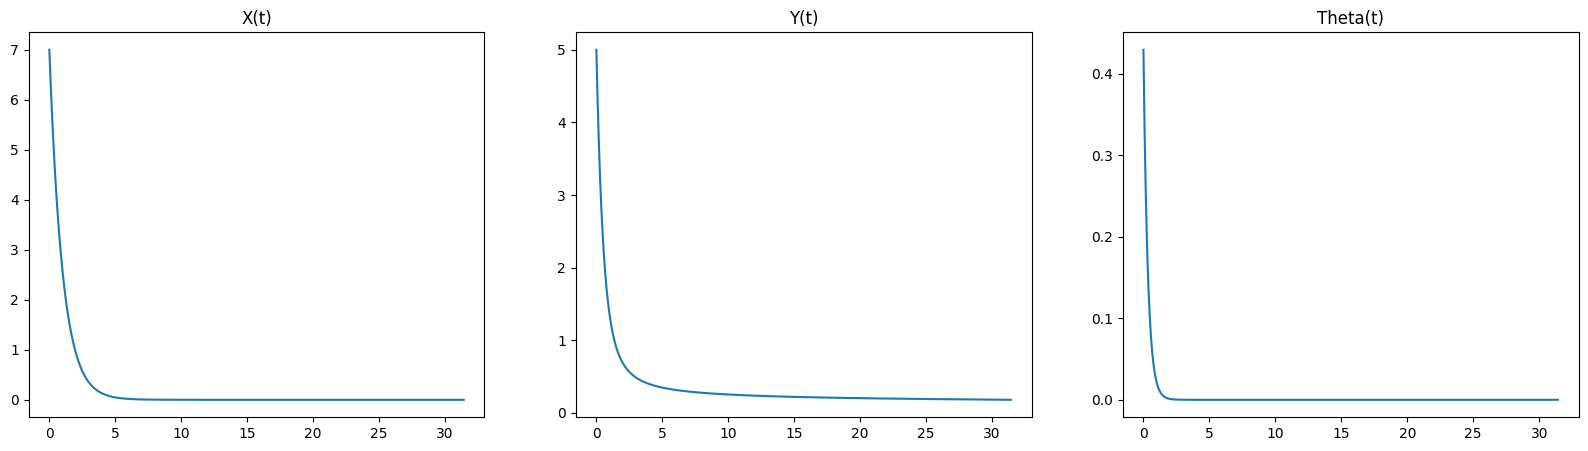

In [339]:
# Plots of errors
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('X(t)')
plt.plot(t, np.abs(state[:, 0] - x_d))
plt.subplot(132)
plt.title('Y(t)')
plt.plot(t, np.abs(state[:, 1] - y_d))
plt.subplot(133)
plt.title('Theta(t)')
plt.plot(t, np.abs(state[:, 2] - th_d))
plt.show()

# Task 2: Flow disturbance and sliding mode:
  * Suppose now that there is disturbance due to river flow $\delta < 1$ (as example you may take $\delta(t) = 2/3+\sin(0.1t)/3$, introduce this to the dynamics and study response of inverse dynamics controller.

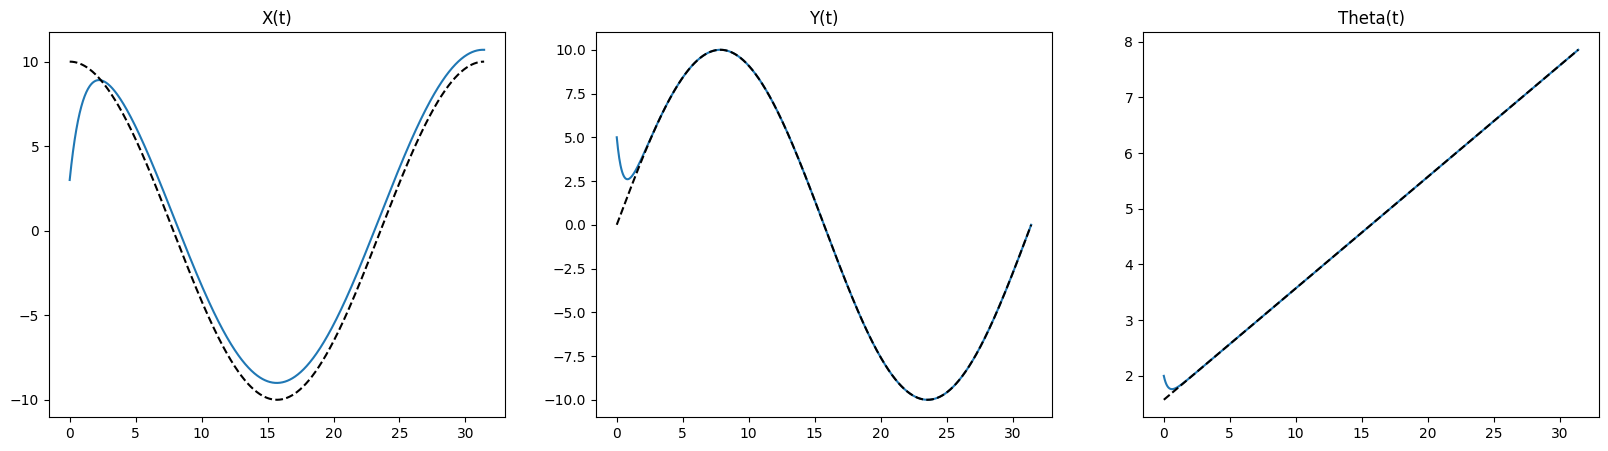

In [340]:
def Control(x, t, poles):
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5
    u = np.array([[-poles[0] * (x[0,0]- x_t)- 2*np.sin(t/5)],
                  [-poles[1] * (x[1,0]- y_t) + 2*np.cos(t/5)],
                  [-poles[2] * (x[2,0]- theta_t) + 1/5]])
    u = Rz(x[2,0]).T@u
    return u

def System(x, t):
    delta = [[2/3 + np.sin(0.1*t)/3],[0],[0]]
    x = np.array(x, dtype='float').reshape((-1, 1))
    v = Control(x, t, poles)
    R = Rz(x[2,0])
    dx_dt = R@v + delta
    return dx_dt.reshape(3)

state = odeint(System, x0, t)

#Used only for plotting
x_d = 10 * np.cos(t/5)
y_d = 10 * np.sin(t/5)
th_d = np.pi/2 + t/5

plotting(t,state,x_d,y_d,th_d)


  * Use sliding mode technique to propose the modification of the inverse dynamics controller that will eleminate the effect of the disturbance. Simulate the response.

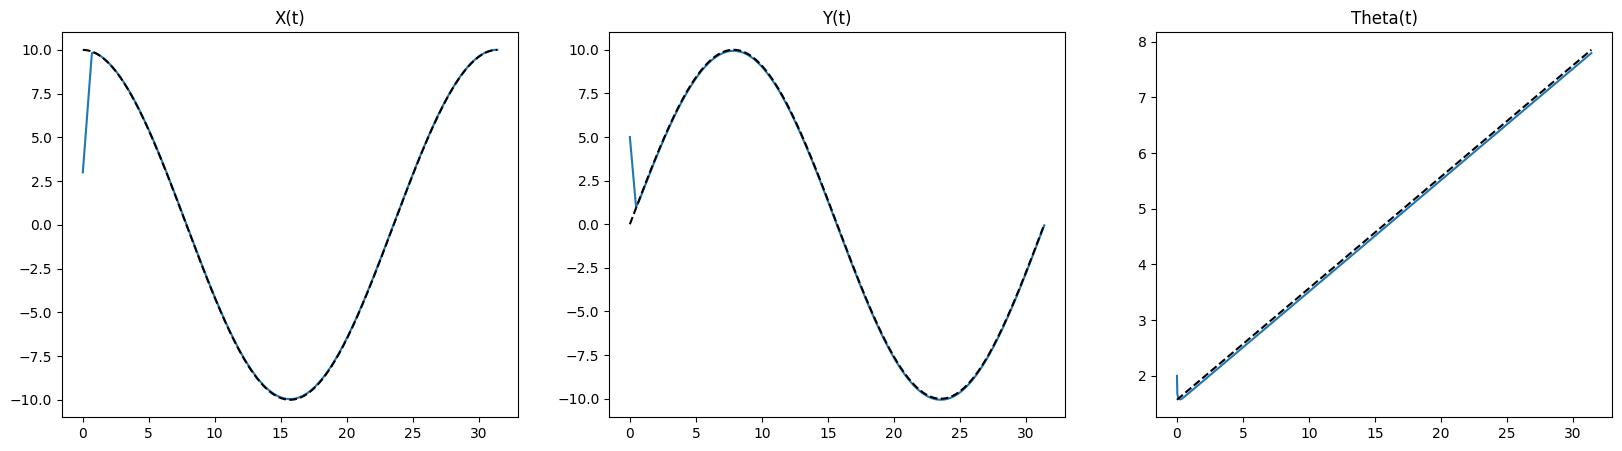

In [341]:
def Control(x, t, poles):
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5

    dx_t = -2 * np.sin(t/5)
    dy_t = 2 * np.cos(t/5)
    dth_t = 1/5

    eta = 0.1
    f_hat = 0.6
    h_hat = 1


    S = np.array([[x[0,0] - x_t],
                  [x[1,0] - y_t],
                  [x[2,0] - theta_t]])

    u_hat = np.array([[(dx_t - f_hat) / h_hat],
                      [(dy_t - f_hat) / h_hat],
                      [(dth_t - f_hat) / h_hat]])

    u_s = np.zeros((3,1))
    for i in range(3):
      if abs(S[i,0]) > eta:
        sgn = np.sign(S[i,0])
        u_s[i,0] = -poles[0]*sgn/eta/h_hat
      else:
        u_s[i,0] = -poles[0]*S[i,0]/eta/h_hat

    u = Rz(x[2,0]).T@(u_hat+u_s)
    return u


state = odeint(System, x0, t)

plotting(t,state,x_d,y_d,th_d)


  * Tune controller such that convergence to the boundary layer given by $\|\tilde{\mathbf{x}}\| < 0.1$ is achieved

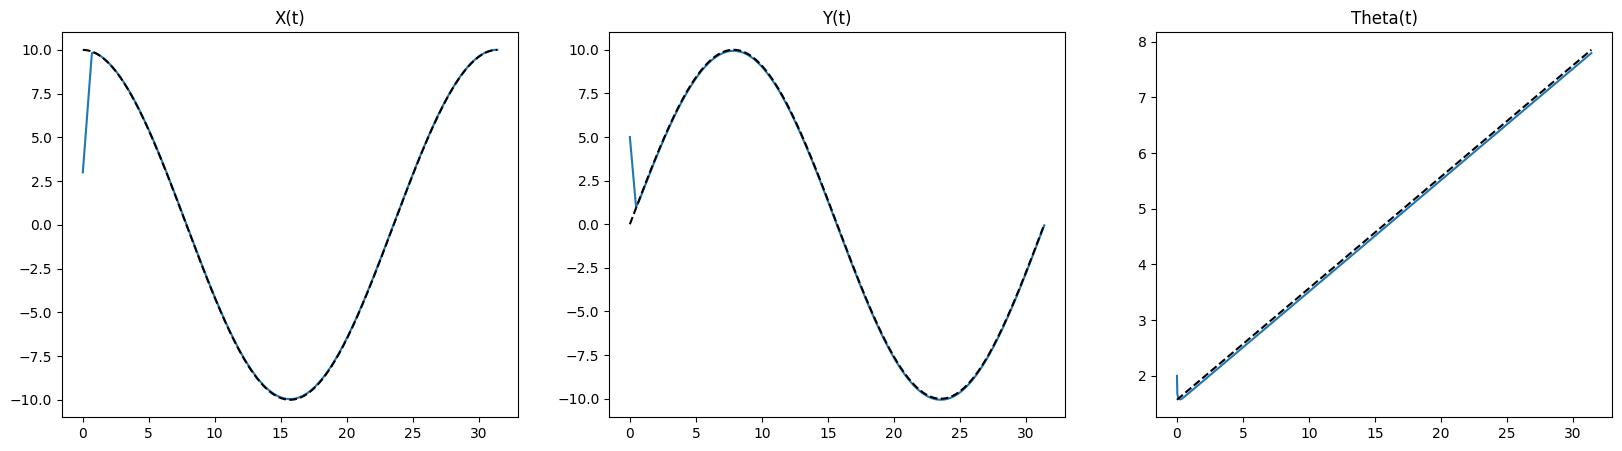

In [342]:
def Control(x, t, poles):
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5

    dx_t = -2 * np.sin(t/5)
    dy_t = 2 * np.cos(t/5)
    dth_t = 1/5

    eta = 0.1
    f_hat = 0.6
    h_hat = 1


    S = np.array([[x[0,0] - x_t],
                  [x[1,0] - y_t],
                  [x[2,0] - theta_t]])

    u_hat = np.array([[(dx_t - f_hat) / h_hat],
                      [(dy_t - f_hat) / h_hat],
                      [(dth_t - f_hat) / h_hat]])

    u_s = np.zeros((3,1))
    for i in range(3):
      if abs(S[i,0]) > eta:
        sgn = np.sign(S[i,0])
        u_s[i,0] = -poles[0]*sgn/eta/h_hat
      else:
        u_s[i,0] = -poles[0]*S[i,0]/eta/h_hat

    u = Rz(x[2,0]).T@(u_hat+u_s)
    return u


state = odeint(System, x0, t)

plotting(t,state,x_d,y_d,th_d)

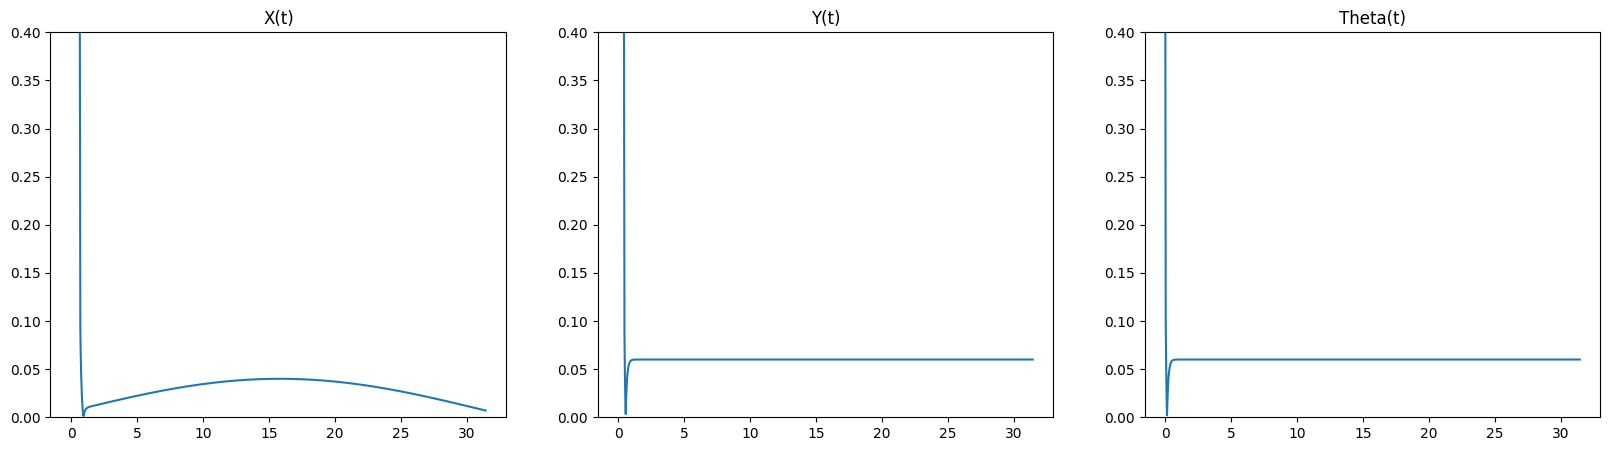

In [343]:
# Plots of errors
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('X(t)')
plt.plot(t, np.abs(state[:, 0] - x_d))
plt.ylim((0,0.4))
plt.subplot(132)
plt.title('Y(t)')
plt.plot(t, np.abs(state[:, 1] - y_d))
plt.ylim((0,0.4))
plt.subplot(133)
plt.title('Theta(t)')
plt.plot(t, np.abs(state[:, 2] - th_d))
plt.ylim((0,0.4))
plt.show()

# Task 3: Adaptive control:
  * Assume now that bounds on the river flow is not known in advance, propose the adaptive control that will estimate the unknown disturbance while tracking the same trajectories

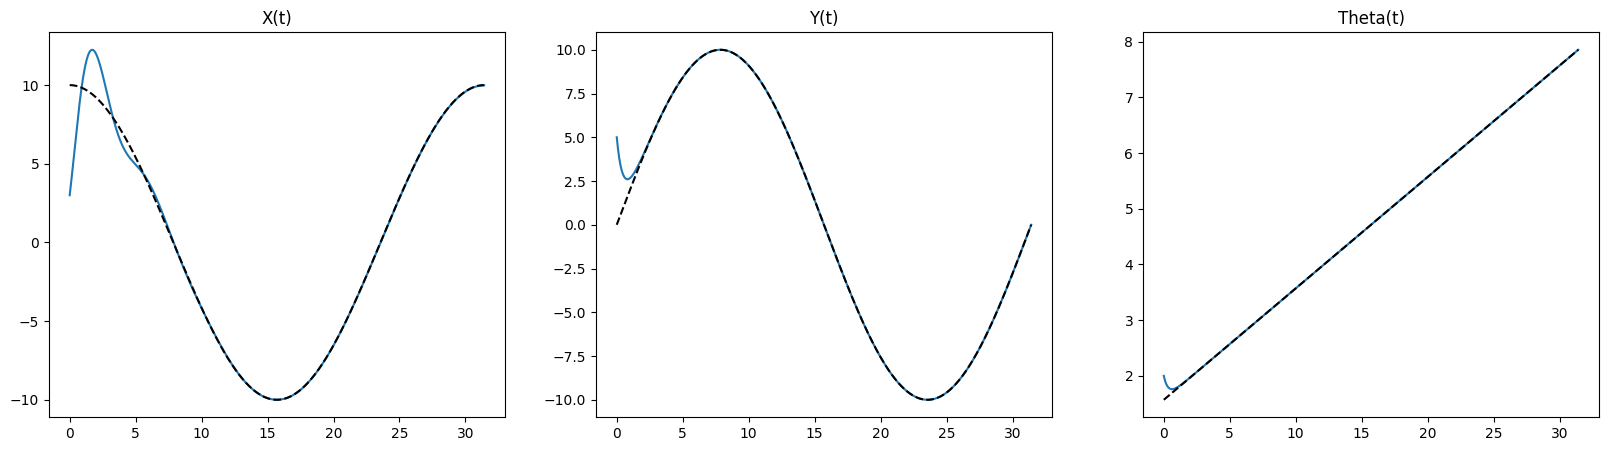

In [344]:
x0 = np.array([x_0, y_0, theta_0])

x0 = np.append(x0, 1/2)

def Control(x, t, poles):
    x_t = 10 * np.cos(t/5)
    y_t = 10 * np.sin(t/5)
    theta_t = np.pi/2 + t/5
    u = np.array([[-poles[0] * (x[0,0]- x_t)- 2*np.sin(t/5) - x[3,0]],
                  [-poles[1] * (x[1,0]- y_t) + 2*np.cos(t/5)],
                  [-poles[2] * (x[2,0]- theta_t) + 1/5]])
    u = Rz(x[2,0]).T@u
    x_e = x_t - x[0,0]
    dp_hat =  -x_e/0.5
    return u, dp_hat

def System(x, t):
    delta = [[2/3 + np.sin(0.1*t)/3],[0],[0]]
    x = np.array(x, dtype='float').reshape((-1, 1))
    v, dp_hat = Control(x, t, poles)
    R = Rz(x[2,0])
    dx_dt = R@v + delta
    return np.append(dx_dt.reshape(3), dp_hat)

state = odeint(System, x0, t)

#Used only for plotting
x_d = 10 * np.cos(t/5)
y_d = 10 * np.sin(t/5)
th_d = np.pi/2 + t/5

plotting(t,state,x_d,y_d,th_d)

* Simulate response and show the convergence of tracking error and flow estimate $\hat{\delta}$

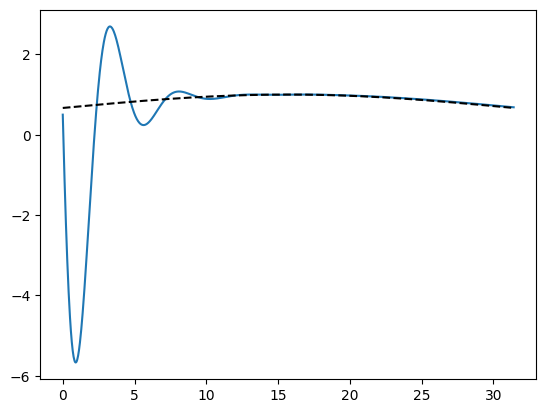

In [354]:
flow = lambda t: 2/3 + 1/3*np.sin(0.1*t)

plt.plot(t, state[:,3])
plt.plot(t, flow(t), color='black', linestyle='--')
plt.show()